# Getting started with imgphon

This notebook demonstrates a sample workflow for extracting normalized lip shapes from video data using `imgphon` and performing dimensionality reduction on the data set using `scikit-learn`.

### Imports 

For details on installing dlib, see the README file.

In [49]:
# -*- coding: utf-8 -*-

from imgphon import helmet 
from imgphon import imgphon as iph # TODO fix issue with detector and predictor
import os, subprocess, glob, re
import numpy as np
import audiolabel
import cv2
import dlib
from imutils.face_utils import FaceAligner
import matplotlib.pyplot as plt

# set some plot properties
%matplotlib inline
plt.rc('font', family='Lato') # IPA-compatible font
plt.rcParams['figure.figsize'] = [x*2 for x in plt.rcParams['figure.figsize']] # double plot window size
plt.rcParams.update({'font.size': 22})

### Required files

`dlib` needs a training data set in order to instantiate its facial landmark predictor. A standard training set can be found at https://github.com/davisking/dlib-models. (This comes as a .bz2 archive and needs to be uncompressed before use.) I use a local copy of this file here; however, in theory, one can use any other training set with desired characteristics.

In [3]:
det = dlib.get_frontal_face_detector()
pred = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')
algn = FaceAligner(predictor, desiredFaceWidth = 256)

### Extracting lip shapes

We will be collecting lip shape and aperture data for the monophthongs of North American English (L1) and standard French (L2) vowels produced by two speakers, plus English onset and coda /l/, onset and coda /ɹ/, and /ɚ/, as produced by two speakers. The video frames used here were extracted from the acoustic midpoints of the monophthongs using the `audiolabel` library by Ron Sprouse. All speakers you see here have given consent for this specific use of their likenesses.

Let's take a first look at the data. After the data has been read in as an ndarray of size (height) x (width) x (channels), here with 3 channels for color, we can pass the image data to `iph.detect_landmarks`, which runs `dlib`'s face detector and landmark locater. The eyes, eyebrows, nose, jawline, and mouth are all detected as a series of 68 (x,y) points, which are returned as `marks` and drawn over the original image (with connecting line segments) using `draw_landmarks`.

All landmarks correspond reasonably well to actual facial features, even though we might expect the ultrasound stabilization helmet to interfere to some extent with this process.

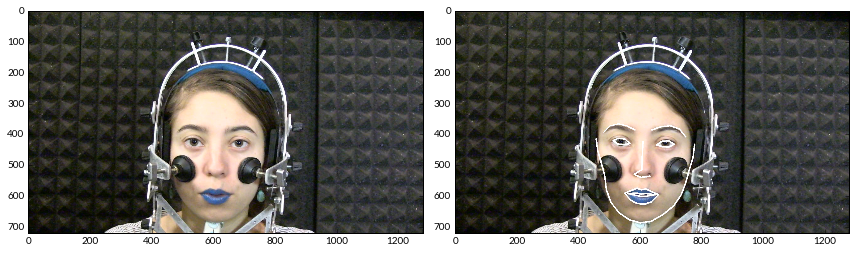

In [4]:
def landmark_plot_prep(target_dir, frame_idx):
    bmp = os.listdir(target_dir)[frame_idx] # get -70th file in dir and ...
    frame = cv2.imread(os.path.join(target_dir, bmp)) # read in as ndarray
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # change color map to RGB for display
    marks = iph.detect_landmarks(frame, detector=det, predictor=pred) # detect landmarks using imgphon
    return rgb, marks
    
rgb,marks = landmark_plot_prep('../40-lip-frames',-70) # get -70th frame for Subject 40 and...

# plot raw data on left; data annotated with detected facial landmarks on right
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.subplot(1,2,2)
plt.imshow(iph.draw_landmarks(rgb,marks,line_width=3))
plt.tight_layout()
plt.show()

(N.B. - the blue lip color was used to test out other feature extraction methods not used here.) 

Importantly, `dlib` detects a variety of lip shapes quite well and returns distinctly shaped lips:

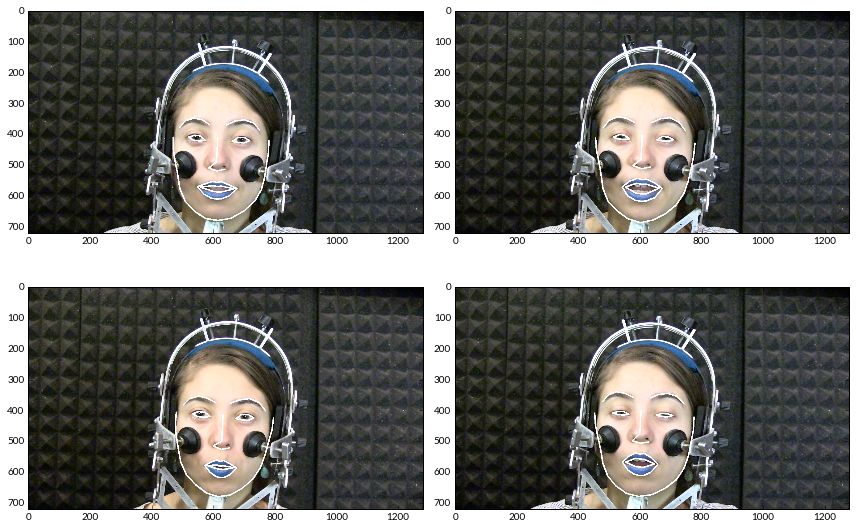

In [5]:
rgb1,marks1 = landmark_plot_prep('../40-lip-frames',0)
rgb2,marks2 = landmark_plot_prep('../40-lip-frames',6)
rgb3,marks3 = landmark_plot_prep('../40-lip-frames',-75)
rgb4,marks4 = landmark_plot_prep('../40-lip-frames',8)

plt.subplot(2,2,1)
plt.imshow(iph.draw_landmarks(rgb1,marks1,line_width=3))
plt.subplot(2,2,2)
plt.imshow(iph.draw_landmarks(rgb2,marks2,line_width=3))
plt.subplot(2,2,3)
plt.imshow(iph.draw_landmarks(rgb3,marks3,line_width=3))
plt.subplot(2,2,4)
plt.imshow(iph.draw_landmarks(rgb4,marks4,line_width=3))
plt.tight_layout()
plt.show() 

The landmark predictor works on a range of faces (complicated by facial hair, glasses, etc), as testing on another speaker will demonstrate. Overall detection does not proceed quite as smoothly with this speaker, since the jawline is partially obscured, but the lips are still reliably detected.

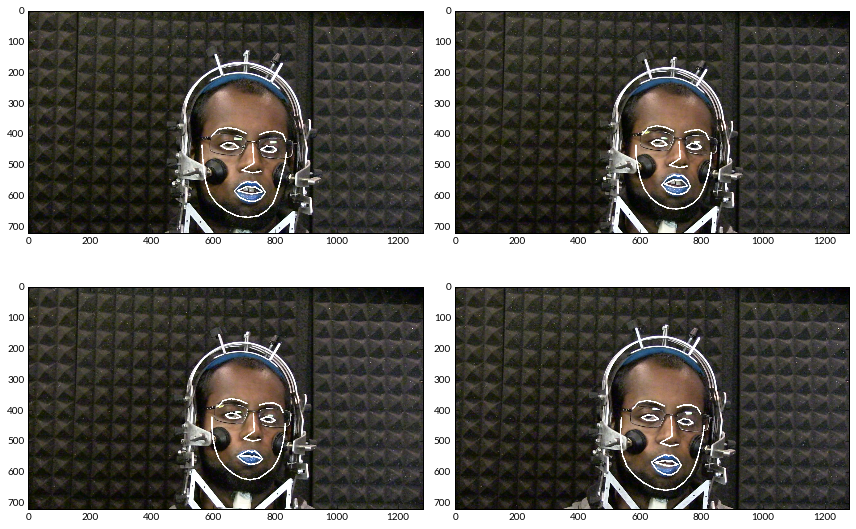

In [6]:
rgb1,marks1 = landmark_plot_prep('../32-lip-frames',17)
rgb2,marks2 = landmark_plot_prep('../32-lip-frames',9)
rgb3,marks3 = landmark_plot_prep('../32-lip-frames',11)
rgb4,marks4 = landmark_plot_prep('../32-lip-frames',-72)

# TODO test 13

plt.subplot(2,2,1)
plt.imshow(iph.draw_landmarks(rgb1,marks1,line_width=3))
plt.subplot(2,2,2)
plt.imshow(iph.draw_landmarks(rgb2,marks2,line_width=3))
plt.subplot(2,2,3)
plt.imshow(iph.draw_landmarks(rgb3,marks3,line_width=3))
plt.subplot(2,2,4)
plt.imshow(iph.draw_landmarks(rgb4,marks4,line_width=3))
plt.tight_layout()
plt.show() 

We could simply extract the lip shapes we get from data like the above and submit them to analysis, but subjects' heads are free to move throughout the experiment, resulting in changes in the absolute location, overall size, and tilt of the extractable lip shape. To improve on this situation, we can normalize the angle and size of the entire face first using the `get_norm_face` function. 

As applied to both faces, we get the following. Note that the faces are scaled to the same relative size and orientation (in spite of the fact that the male subject was seated further away from the teleprompter). The `FaceAligner` implemented in `imutils` and used in the `get_norm_face` function also crops the image closer to the detected face.

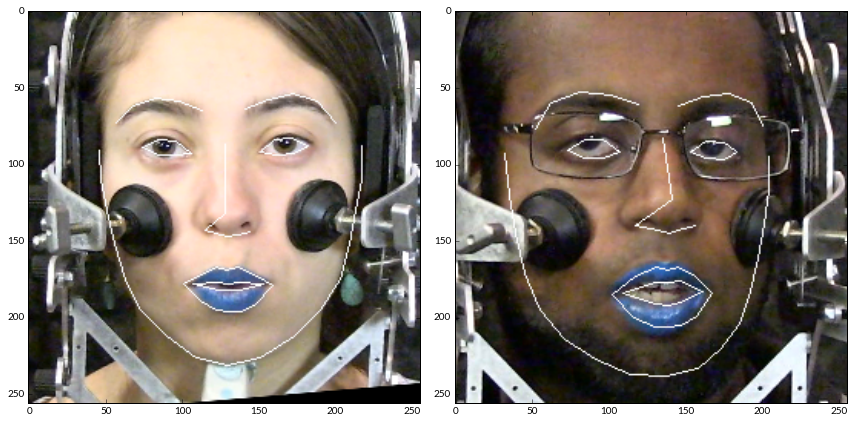

In [11]:
rgbF,marksF = landmark_plot_prep('../40-lip-frames',-75) # the female subject
alignF = iph.get_norm_face(rgbF, detector=det, predictor=pred, aligner=algn)
align_marksF = iph.detect_landmarks(alignF, detector=det, predictor=pred)

rgbM,marksM = landmark_plot_prep('../32-lip-frames',-72) # the male subject
alignM = iph.get_norm_face(rgbM, detector=det, predictor=pred, aligner=algn)
align_marksM = iph.detect_landmarks(alignM, detector=det, predictor=pred)

plt.subplot(1,2,1)
plt.imshow(iph.draw_landmarks(alignF,align_marksF,line_width=1))
plt.subplot(1,2,2)
plt.imshow(iph.draw_landmarks(alignM,align_marksM,line_width=1))
plt.tight_layout()
plt.show()

We can also isolate the lips using the `lip_mask` function and center them on a ground of consistent size using the `crop_center` function. As applied to the data immediately above:

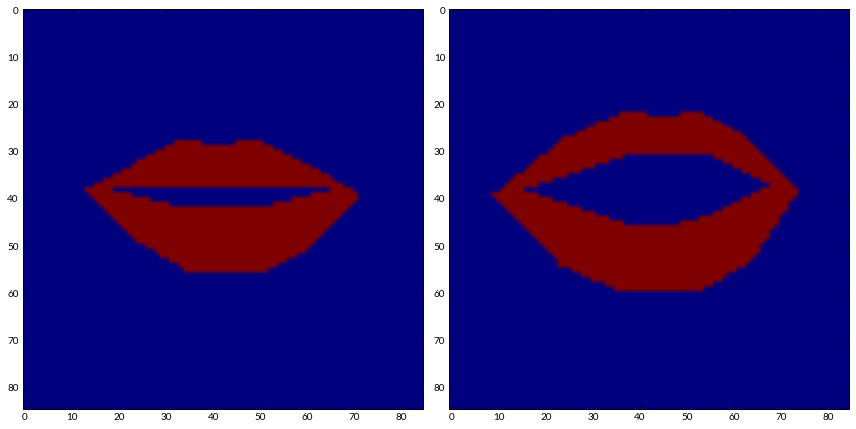

In [12]:
maskF = iph.lip_mask(alignF, align_marksF)
maskM = iph.lip_mask(alignM, align_marksM)

plt.subplot(1,2,1)
plt.imshow(iph.crop_center(maskF))
plt.subplot(1,2,2)
plt.imshow(iph.crop_center(maskM))
plt.tight_layout()
plt.show()

Collapsing all of the steps taken cell-by-cell above, we can view all lip shapes all at once for both subjects. First, we collect a set of rotated and corrected faces for each subject, detect face landmarks on each face, and extract the lip polygons.

In [16]:
target_dir = '../40-lip-frames'
bmp_glob = os.path.join(os.path.abspath(target_dir),"*.bmp")

masks40 = []
for bmp in sorted(glob.glob(bmp_glob)):
    frame = cv2.imread(bmp) # read in as ndarray
    align = iph.get_norm_face(frame, detector=det, predictor=pred, aligner=algn)
    marks = iph.detect_landmarks(align, detector=det, predictor=pred)
    mask = iph.lip_mask(align, marks)
    mask = iph.crop_center(mask)
    masks40.append(mask)
    
target_dir = '../32-lip-frames'
bmp_glob = os.path.join(os.path.abspath(target_dir),"*.bmp")

masks32 = []
for bmp in sorted(glob.glob(bmp_glob)):
    frame = cv2.imread(bmp) # read in as ndarray
    align = iph.get_norm_face(frame, detector=det, predictor=pred, aligner=algn)
    marks = iph.detect_landmarks(align, detector=det, predictor=pred)
    mask = iph.lip_mask(align, marks)
    mask = iph.crop_center(mask)
    masks32.append(mask)

We can then display the mean for each pixel over all of the captured lip shapes. Note that global differences in posture (especially the male subject's head being turned slightly to one side) and lip shape are captured.

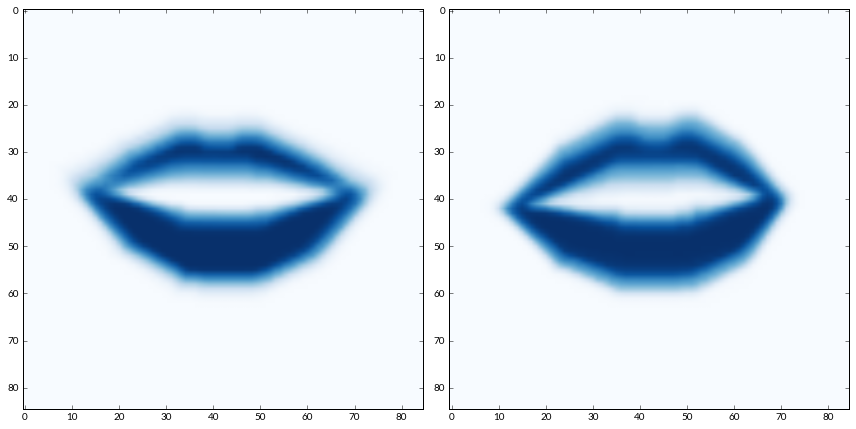

In [17]:
mu40 = np.mean(masks40,axis=0)
mu32 = np.mean(masks32,axis=0)

plt.subplot(1,2,1)
plt.imshow(mu40,cmap="Blues")
plt.subplot(1,2,2)
plt.imshow(mu32,cmap="Blues")
plt.tight_layout()
plt.show()

# Dimensionality reduction

Having assembled our data set, we find ourselves with (still) very high-dimensional data that is subjected to some noise. To clean up the data and reduce dimensionality, we undertake a principal components analysis (PCA) using utilities from `sklearn`. The cell below finds the first 20 principal components (PCs) that explain the most variation in the data we assembled above. We will focus on Speaker 40 here.

In [18]:
from sklearn.decomposition import PCA

mask_array = np.stack(masks40) # convert list of ndarrays to ndarray

mask_array_flat = mask_array.reshape([  # flatten the data so that it is one vector of 85*85 pixel values
        mask_array.shape[0],
        mask_array.shape[1] * mask_array.shape[2]
    ])

n_comp = 20
pca = PCA(n_components=n_comp) # run PCA
pca.fit(mask_array_flat)

PCA(copy=True, n_components=20, whiten=False)

We can visualize these components as the extent to which each pixel in the basis data varies as a part of that component. In the image below, extreme low values of the PCs are plotted in red, extreme low values are plotted in blue, and neutral values are in white. 

For PC1 (left), a low loading means a generally smaller lip aperture (i.e., rounding) and a high loading means a generally wider lip aperture. Low loadings of PC2 appear to indicate either an open vowel or a rounded vowel; high loadings have a more neutral lip posture.

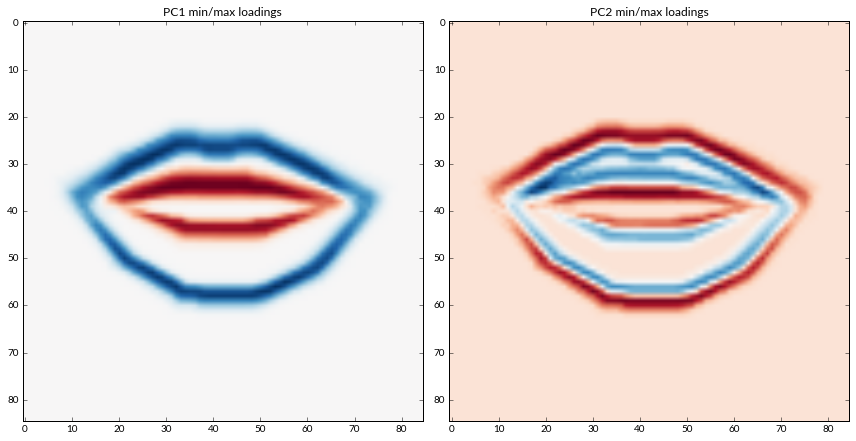

In [19]:
image_shape = (85,85) # define a shape to cast the data back into
def pc_loading(pc_num):
    image_shape = (85,85)
    dd = pca.components_[pc_num-1].reshape(image_shape) # get the n-1th PC from the list of PCs
    mag = np.max(dd) - np.min(dd) # get magnitude of effect of PC by pixel
    pc_load = (dd-np.min(dd))/mag*255 # scale to 0-255 range
    return pc_load

plt.subplot(1,2,1)
plt.title("PC1 min/max loadings")
plt.imshow(pc_loading(1), cmap="RdBu") # red for low values, blue for high values
plt.subplot(1,2,2)
plt.title("PC2 min/max loadings")
plt.imshow(pc_loading(2), cmap="RdBu")
plt.tight_layout()
plt.show()

We can also explore the basis data using the PCs. We can, for instance, look for clustering in PC1-PC2 space.

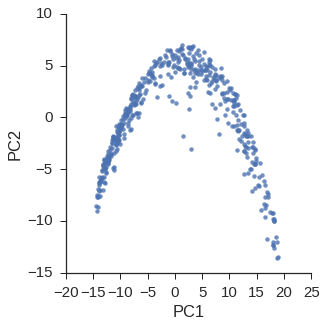

In [47]:
import pandas as pd
import seaborn as sns
sns.set_style("ticks")

analysis = pca.transform(mask_array_flat) # characterize data as scaled combinations of PCs
df = pd.DataFrame(analysis) # convert to pandas DataFrame object
df.columns = ["PC{}".format(pc+1) for pc in range(n_comp)]

sns.lmplot("PC1", 
           "PC2", 
           data=df, 
           fit_reg = False,
           size=5)

Of course, this is not terribly interesting without some information on linguistic categories. Adding some metadata on which English or French vowel (or consonant) is being produced for each token, additional structure emerges. The plot below shows labeled by-phone medians for PC1 and PC2 for the various French and English phones. Rounded vowels from both languages appear to have low PC1, and rounded and open vowels both have low PC2, as we might expect from the loading plots above.

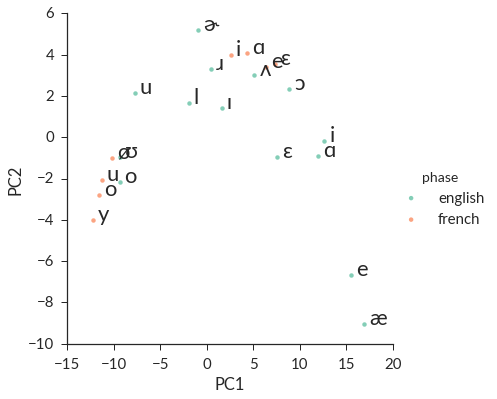

In [50]:
# -*- coding: utf-8 -*-
md = pd.read_csv('../40-lip-frames/40_vid_metadata.csv', encoding='utf-8') # conveniently available segment metadata
df = df.assign(phone=pd.Series(md['uniquePhone']).values) # add in segment metadata
df = df.assign(phase=pd.Series(md['phase']).values)

meds = df[['PC1','PC2','phone', 'phase']].groupby(['phone','phase']).median().reset_index()
pal = sns.color_palette("Set2", 15)
fgrid = sns.lmplot("PC1", 
                   "PC2", 
                   data=meds, 
                   hue="phase",
                   palette=pal,
                   fit_reg = False,
                   size=6)
for r in meds.itertuples(): # itertuples
    fgrid.axes[0,0].annotate(r.phone, (r.PC1, r.PC2), xytext=(5,0), textcoords='offset points')

Some interesting observations can be drawn from this data. 

For instance, there are some clear qualitative differences in lip posture used for some pairs of English and French vowels that one would expect to be identifiable with one another and perhaps represented similarly across the two languages (e.g. English and French /i u e o a/). These differences could be taken as illustrative of language-specific targets for these pairs of vowels.

Furthermore, the portions of PC1-PC2 space used by the speaker for each language are strikingly different: the high-PC1, low-PC2 "tail" is populated entirely by English front and low vowels, and the French vowels are less distributed than the English vowels, showing up in two clear clusters (rounded and non-rounded).